In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from itertools import combinations

%matplotlib inline

In [26]:
n_classes = 5
n_clf = n_classes * (n_classes - 1) // 2
c_groups = [(t[1],t[0]) for t in list(combinations(list(range(0,n_classes)),2))]

In [4]:
def real_data():
    data = pd.read_csv('processed.cleveland.data', names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'], header=None)
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data


In [5]:
def synthetic_data():
    #mean1 = np.concatenate((np.ones(1)*-10,np.ones(12)))
    #mean2 = np.concatenate((np.ones(12),np.ones(1)*10))
    mean0 = np.ones(13)*1
    mean1 = np.ones(13)*7
    mean2 = np.ones(13)*10
    mean3 = np.ones(13)*5
    mean4 = np.ones(13)*8
    g0 = np.random.multivariate_normal(mean0, np.eye(13), size=1580)
    g1 = np.random.multivariate_normal(mean1, np.eye(13), size=550)
    g2 = np.random.multivariate_normal(mean2, np.eye(13), size=360)
    g3 = np.random.multivariate_normal(mean3, np.eye(13), size=350)
    g4 = np.random.multivariate_normal(mean4, np.eye(13), size=130)

    
    y0 = np.asarray([0]*1580).reshape(1580,1)
    y1 = np.asarray([1]*550).reshape(550,1)
    y2 = np.asarray([2]*360).reshape(360,1)
    y3 = np.asarray([3]*350).reshape(350,1)
    y4 = np.asarray([4]*130).reshape(130,1)


    #y1 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y2 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y3 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y4 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    
    g0 = np.concatenate((g0,y0), axis=1)
    g1 = np.concatenate((g1,y1), axis=1)
    g2 = np.concatenate((g2,y2), axis=1)
    g3 = np.concatenate((g3,y3), axis=1)
    g4 = np.concatenate((g4,y4), axis=1)

    g = np.concatenate([g0,g1,g2,g3,g4], axis=0)

    d = pd.DataFrame(data=g, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
    return d

#d1 = pd.DataFrame(data=g1, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d2 = pd.DataFrame(data=g2, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d3 = pd.DataFrame(data=g3, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d4 = pd.DataFrame(data=g4, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#plt.scatter(g1[:,0], g1[:,1],g1[:,2], c='b')
#plt.scatter(g2[:,0], g2[:,1],g2[:,2], c='r')
#plt.scatter(g3[:,0], g3[:,1],g3[:,2], c='g')
#plt.scatter(g4[:,0], g4[:,1],g4[:,2], c='y')
#plt.show()

In [48]:
#data = synthetic_data()
data = real_data()

## split data into train and test
cols = list(data.columns)
cols.remove('num')
target = data['num'].copy()
input_data = data[cols].copy()
#target_bin = label_binarize(target, classes=[0, 1, 2, 3, 4])
#test removing healthy patients
dTrain, dTest, targetTrain, targetTest = train_test_split(input_data, target, test_size=0.20, stratify=target)
scaler = preprocessing.StandardScaler().fit(dTrain)
dTrain = scaler.transform(dTrain)
ovo = OneVsOneClassifier(SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0), n_jobs=-1)
ovo.fit(dTrain, targetTrain)

dTest = scaler.transform(dTest)
targetTestBin = label_binarize(targetTest, classes=[0, 1, 2, 3, 4])
#probas = ovo.decision_function(dTest)
#print(np.argmax(probas, axis=1))
pred_2 = ovo.predict(dTest)
print(pred_2)
#pred = np.argmax(probas, axis=1)
print(c_groups)
votes = np.zeros(targetTestBin.shape)
for i in range(n_clf):
    clf_ = ovo.estimators_[i]
    proba = clf_.decision_function(dTest)
    #print(proba)
    for j, p in enumerate(proba):
        #print(p)
        if p > 0:
            votes[j, c_groups[i][0]] += 1
        else:
            votes[j, c_groups[i][1]] += 1

pred = np.argmax(votes, axis=1).astype(float)
#print(votes)
print(pred)

cm = confusion_matrix(targetTest, pred_2).T
print(cm)
acc = (cm.diagonal() / cm.sum(axis=0)).sum()/n_classes
print(acc)
#test removing healthy patients

[ 0.  1.  0.  4.  0.  0.  3.  2.  0.  1.  1.  0.  0.  2.  0.  0.  1.  0.
  1.  0.  0.  0.  2.  0.  0.  4.  2.  4.  0.  3.  4.  3.  2.  1.  0.  2.
  0.  3.  0.  3.  1.  0.  3.  4.  1.  4.  3.  0.  0.  0.  3.  2.  3.  2.
  0.  2.  2.  2.  1.  3.]
[(1, 0), (2, 0), (3, 0), (4, 0), (2, 1), (3, 1), (4, 1), (3, 2), (4, 2), (4, 3)]
[ 0.  1.  0.  4.  0.  0.  3.  2.  0.  1.  1.  0.  0.  2.  0.  0.  1.  0.
  1.  0.  0.  0.  2.  0.  0.  4.  2.  4.  0.  3.  2.  3.  1.  1.  0.  2.
  0.  3.  0.  3.  1.  0.  3.  4.  1.  4.  2.  0.  0.  0.  3.  2.  3.  2.
  0.  2.  2.  2.  1.  2.]
[[22  2  0  0  0]
 [ 7  1  1  0  0]
 [ 2  3  3  2  1]
 [ 0  5  2  1  2]
 [ 1  0  1  4  0]]
0.269967532468


In [28]:
#optimal cutpoints

#find the closest point to (0,1) coordinate
def roc01(fpr, tpr):
    tl = [0,1]
    index = None
    opt = np.inf
    for i in range(len(fpr)):
        d = np.linalg.norm(np.array(tl) - np.array([fpr[i], tpr[i]]))
        if d < opt:
            opt = d
            index = i
    return fpr[index], tpr[index]

#Youden's index
def youden_index(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt = -1
    for i in range(len(fpr)):
        pt = sp[i]+se[i]
        if pt > opt:
            opt = pt
            index = i
            
    return fpr[index], tpr[index]
    
#maximize sensitivity
def max_se(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if se[i] > opt_se:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(se[i]-opt_se) <= threshold:
            if sp[i] > opt_sp:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]

#maximize specificity
def max_sp(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if np.isclose(fpr[i],0.0):
            continue
        if sp[i] > opt_sp:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(sp[i]-opt_sp) <= threshold:
            if se[i] > opt_se:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]
                

Maximize sensitivity and specificity

0.67002015422
0.334516171961
0.906553787831


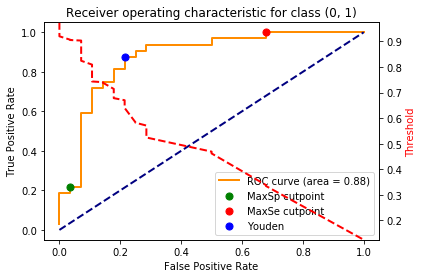

0.85821873736
0.090900502239
0.996291084109


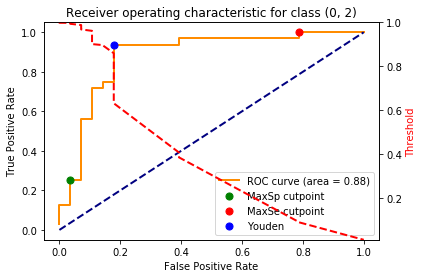

0.858734580901
0.424266261249
0.977804213316


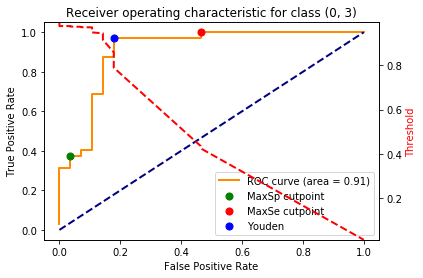

0.984417314767
0.421391102051
0.996136544563


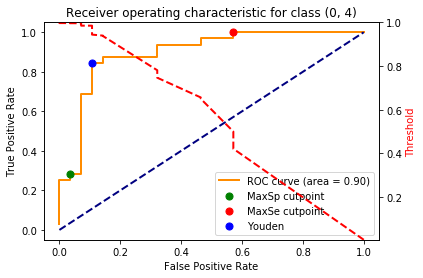

0.5
0.5
0.79622066442


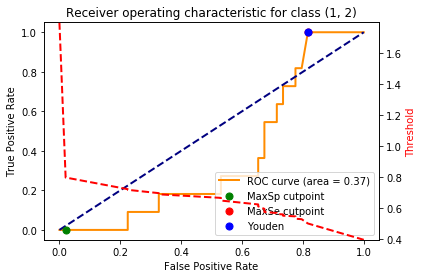

0.347247971277
0.316633315391
0.8683479797


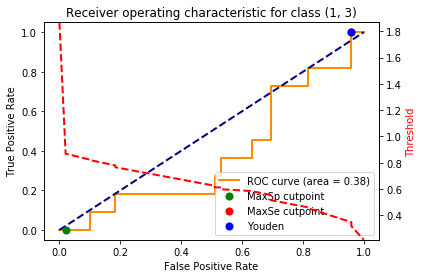

0.58525081214
0.554371952864
0.961489986999


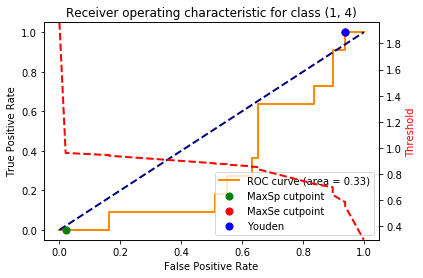

0.426476204153
0.415218876347
0.81395585598


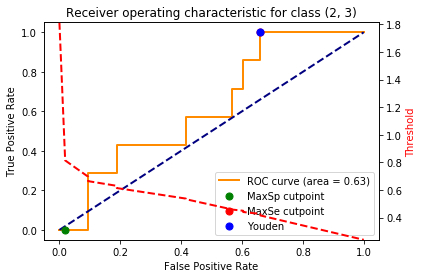

0.832604766121
0.563928115326
0.913262267915


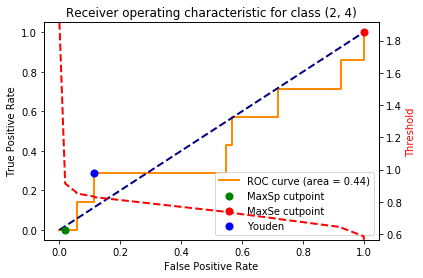

0.770098318811
0.769533339042
0.844030193917


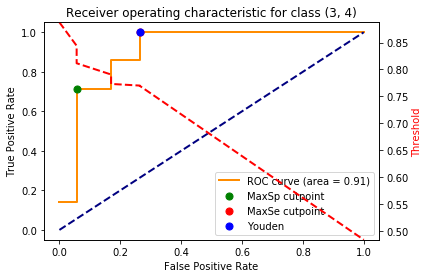

In [49]:
clf_index = 0
probas = []
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
cutpoints = dict()
#for i in range(5):
#test removing healthy patients
for i in range(n_classes):
    for j in range(n_classes):
        if j > i:
            clf = ovo.estimators_[clf_index]
            proba = clf.predict_proba(dTest)
            probas.append(proba)
            fpr[clf_index], tpr[clf_index], thresholds[clf_index] = roc_curve(targetTestBin[:, i], proba[:, 0])
            roc_auc[clf_index] = auc(fpr[clf_index], tpr[clf_index])
            clf_index += 1
#for i in range(5):
#test removing healthy patients

for i in range(n_clf):
    opt_cutpoint1 = max_sp(fpr[i], tpr[i])
    opt_cutpoint2 = max_se(fpr[i], tpr[i])
    opt_cutpoint3 = youden_index(fpr[i], tpr[i])
    #print(fpr[i], tpr[i])
    #print(np.where(fpr[i] == opt_cutpoint1[0])[0][0])
    #print(np.where(fpr[i] == opt_cutpoint2[0])[0][-1])
    c_index1 = np.where(fpr[i] == opt_cutpoint1[0])[0][0]
    c_index2 = np.where(fpr[i] == opt_cutpoint2[0])[0][-1]
    c_index3 = np.where(fpr[i] == opt_cutpoint3[0])[0][0]
    if c_index1 == 0:
        c_index1 += 1
    if c_index2 == 0:
        c_index2 += 1
    if c_index3 == 0:
        c_index3 += 1
    
    
    cutpoints[i] = (thresholds[i][c_index3], thresholds[i][c_index2], thresholds[i][c_index1])
    #print(thresholds[i], c_index1, c_index2)
    print(thresholds[i][c_index3])
    print(thresholds[i][c_index2])
    print(thresholds[i][c_index1])
    fig, ax = plt.subplots()
    lw = 2
    ax.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i], zorder=-1)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', zorder=-1)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class ' + str(tuple(reversed(c_groups[i]))))
    ax.scatter(opt_cutpoint1[0], opt_cutpoint1[1], c='g', zorder=1, label='MaxSp cutpoint', s=50)
    ax.scatter(opt_cutpoint2[0], opt_cutpoint2[1], c='r', zorder=1, label='MaxSe cutpoint', s=50)
    ax.scatter(opt_cutpoint3[0], opt_cutpoint3[1], c='b', zorder=1, label='Youden', s=50)
    ax.legend(loc="lower right")
    
    ax2 = plt.gca().twinx()
    ax2.plot(fpr[i], thresholds[i], color='r', lw=lw, linestyle='--', zorder=-1)
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[i][-1],thresholds[i][0]])
    ax2.set_xlim([-0.05, 1.05])
    plt.show()

In [52]:
class_votes = np.zeros(targetTestBin.shape)
for i in range(n_clf):
    clf = ovo.estimators_[i]
    proba = probas[i]
    for j, p in enumerate(proba.max(axis=1)):
        if p > cutpoints[i][0] or np.isclose(p,cutpoints[i][0]):
            class_votes[j, c_groups[i][1]] += 1
        else:
            class_votes[j, c_groups[i][0]] += 1
            
        #if p > cutpoints[i][0] or np.isclose(p,cutpoints[i][0]):
        #    class_votes[j, c_groups[i][0]] += 1
        #elif p < cutpoints[i][1] or np.isclose(p,cutpoints[i][1]):
        #    class_votes[j, c_groups[i][1]] += 1
        #else:
        #    class_votes[j, c_groups[i][0]] += 1
        #    class_votes[j, c_groups[i][1]] += 1
            
new_preds = np.argmax(class_votes, axis=1)
print(np.where(targetTest == 1)[0].shape[0])
cm_2 = confusion_matrix(targetTest, new_preds).T
print(cm)
print(cm_2)
print(cm_2.sum(axis=0))
acc_2 = (cm_2.diagonal() / cm_2.sum(axis=0)).sum()/n_classes
print(acc_2)
m = np.stack((new_preds, np.asarray(targetTest).astype(int), pred.astype(int)), axis=0)
print(m.T)
#print('new: ', new_preds)
#print('real: ', np.asarray(targetTest).astype(int))
#print('old: ', pred.astype(int))

11
[[22  2  0  0  0]
 [ 7  1  1  0  0]
 [ 2  3  3  2  1]
 [ 0  5  2  1  2]
 [ 1  0  1  4  0]]
[[23  4  1  2  1]
 [ 9  7  6  5  2]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
[32 11  7  7  3]
0.271022727273
[[0 0 0]
 [1 0 1]
 [0 0 0]
 [1 0 4]
 [0 0 0]
 [0 0 0]
 [1 1 3]
 [1 1 2]
 [0 0 0]
 [0 0 1]
 [1 0 1]
 [0 0 0]
 [0 0 0]
 [1 1 2]
 [0 0 0]
 [1 0 0]
 [0 1 1]
 [0 0 0]
 [1 0 1]
 [0 1 0]
 [0 0 0]
 [0 1 0]
 [1 2 2]
 [0 0 0]
 [0 0 0]
 [0 3 4]
 [1 0 2]
 [1 3 4]
 [0 0 0]
 [1 2 3]
 [0 3 2]
 [1 4 3]
 [1 3 1]
 [1 0 1]
 [0 0 0]
 [1 2 2]
 [0 0 0]
 [1 1 3]
 [0 0 0]
 [1 1 3]
 [1 0 1]
 [0 0 0]
 [1 3 3]
 [0 2 4]
 [0 0 1]
 [1 3 4]
 [0 1 2]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 3]
 [1 0 2]
 [1 2 3]
 [1 4 2]
 [0 0 0]
 [1 2 2]
 [1 1 2]
 [1 3 2]
 [1 2 1]
 [0 4 2]]


In [ ]:
ova = pd.read_csv('confusion_matrix_ova.csv', header=None)
print(ova)